# Clustering Analisis with mixed cat / num variables

### References
- [prince 0.7.1 - Project description](https://pypi.org/project/prince/#principal-component-analysis-pca)
- [TowardsDataScience - "Are You Still Using the Elbow Method?"](https://towardsdatascience.com/are-you-still-using-the-elbow-method-5d271b3063bd) --> [Notebook in Github](https://github.com/smazzanti/are_you_still_using_elbow_method/blob/main/are-you-still-using-elbow-method.ipynb)

In [80]:
%%capture
!pip install prince

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import prince
from prince import FAMD
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sklearn_metrics
import math
random_state = 1234

In [82]:
prince.__version__

'0.7.1'

### functions

In [144]:
## Analysis of numerical variables with PCA
def analysis_pca(X:np.array, y:np.array = None, n_components:int = 2):
    """
    Analysis of numerical variables with PCA.
    X -- df or numpy array with numerical features to be analized.
    y -- df series or numpy array with labels to be used to PCs distribution chart.
    n_components -- number of components to be used (default, 2).
    """

    # initialize PCA
    pca = prince.PCA(
         n_components=n_components,
         n_iter=3,
         rescale_with_mean=True,
         rescale_with_std=True,
         copy=True,
         check_input=True,
         engine='auto',
         random_state=42
    )
    # fit PCA
    pca = pca.fit(X)
    # display
    print(f"Number of components selected = {n_components}")
    explained_intertia = pca.explained_inertia_
    total_inertia = np.sum(explained_intertia)
    unexplained_intertia = 1. - total_inertia
    print(f'How much each PC explains part of the underlying of the distribution: {explained_intertia} / Total = {total_inertia} / Unexplained inertia = {unexplained_intertia}')
    # transform
    cs = pca.transform(X)
    
    # plot components 2 first components
    print("Two first components distribution:")
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize = (10,8))
    ax = pca.plot_row_coordinates(
         X,
         ax=ax,
         #figsize=(6, 6),
         x_component=0,
         y_component=1,
         labels=None,
         color_labels= None if y is None else y,
         ellipse_outline=False,
         ellipse_fill=True,
         show_points=True
    )
    plt.show()    
    
    # correlation between components and variables
    print('Correlation between components and variables:')
    display(pca.column_correlations(X))
    
    # rows contribution
    rows_contribution = pca.row_contributions(X)
    rows_ratio_contribution = rows_contribution / X.shape[0]
    # plot percent of rows contribution
    print("Rows contribution distribution:")
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize = (10, 6))
    rows_ratio_contribution.plot(ax = ax)
    ax.set_title("Percent of rows contribution", fontsize = 12)
    ax.set_xlabel("Index")
    ax.set_ylabel("%")
    plt.show()   
    
    # return 
    return None


## Automated selection of number of PCs para PCA
def pca_number_pcs_auto_selection(X:np.array, variance_threshold:float = .95, verbose:bool = False):
    """
    Automated selection of number of PCs para PCA.
    X -- df or numpy array with numerical features to be analized.
    variance_threshold -- percent of variance to be used as cut-off threshold.
    verbose -- display extra information (default, False).
    return -- optimed number of pcs.
    """
    # loop of possible components number
    for nc in np.arange(1, X.shape[1]+1, 1):
        # initialize pca
        total_explained_inertia = np.sum(prince.PCA(n_components=nc).fit(X).explained_inertia_)
        # validate
        if total_explained_inertia >= variance_threshold:
            # display result
            if verbose:
                print(f"Optimal number of PCs for {variance_threshold*100.}% cut-off threshold = {nc}")
            # return value of components number
            return nc
    # return if it is not found nothing
    return np.nan


def calinski_harabasz_score(X, labels):
  """Wrapper function of Scikit-learn's calinski_harabasz_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.calinski_harabasz_score(X, labels)


def kmeans_labels(X, n_clusters):
    """Gives the same result of Scikit-learn's Kmeans, but it doesn't throw an error when n_clusters = 1."""
    if n_clusters == 1:
        return np.repeat(a=0, repeats=len(X))
    else:
        return KMeans(n_clusters=n_clusters).fit(X).labels_
    

def local_maximums_metric(possible_k:np.array, array_metrics:np.array)->np.array:
    # inputs validation
    assert len(possible_k) == len(array_metrics)
    # build df
    dfs = pd.DataFrame({'num_clusters':possible_k,'metric':array_metrics}).set_index("num_clusters")
    # estimate slopes
    dfs['metric_slope'] = dfs.diff() >= 0
    # collect data
    slopes = dfs.metric_slope.values
    num_clusters = dfs.index.values
    # initialize output
    local_maximums = list()
    # loop of metric values
    for i in range(1, len(dfs), 1):
        # validate if is a local maximum
        if slopes[i-1] == True and  slopes[i] == False:
            # append result
            local_maximums.append(num_clusters[i-1])
    # return results
    return np.array(local_maximums)
    

def estimate_num_clusters_candidates(X:np.array, num_clusters_max:int=25, verbose:bool = False)->np.array:
    # input validation
    assert type(X) is np.array or type(X) is np.ndarray, "It is required data container be a Numpy array."
    # list of possible clusters number values
    possible_k = np.arange(1,25,1)  
    # initialize
    ss = list()
    # loop of possible values
    for k in possible_k:
        # get labels of clustering
        labels = kmeans_labels(X, n_clusters=k)
        # get metric
        s = calinski_harabasz_score(X, labels)
        # validate metrix
        if np.isnan(s):
            s = 0.
        # append metric value  
        ss.append(s)
    # list to array
    ss = np.array(ss)
    # estimate local maximums to get number of cluster candidates
    num_clusters_metric = local_maximums_metric(possible_k, ss)
    # return all of candidates
    return num_clusters_metric, ss


def plot_cluster(X, y, ax, title="Cluster plot"):
    ax = X.plot.scatter(x=0, y=1, c=y, title = title, edgecolor='black', s=50, alpha = .5, colormap = 'jet', ax = ax)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    return ax


def plot_metric(possible_k:np.array, array_metrics:np.array, ax, num_clusters_metric=None):
    ax.plot(possible_k, array_metrics, color = 'blue', alpha = .5)
    ax.scatter(possible_k, array_metrics, color = 'blue', edgecolor='black')
    ax.set_ylim([np.min(array_metrics[array_metrics>0]-np.std(array_metrics[array_metrics>0])),np.max(array_metrics)+np.std(array_metrics[array_metrics>0])])
    ax.set_xticks(possible_k)
    ax.set_xticklabels(possible_k, rotation='horizontal',fontsize='small')
    ax.set_xlabel("number of clusters")
    ax.set_ylabel("Calinski Harabasz score")
    ax.set_title("Number of clusters selection")
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    if not num_clusters_metric is None:
       for v in num_clusters_metric:
        ax.axvline(v, color='red', linestyle='--', alpha = .5)
    return ax

## Clustering Analysis: Only Numerical Variables

### dataset: Iris datast

In [145]:
# load data
X, y = datasets.load_iris(return_X_y=True)
X = pd.DataFrame(data=X, columns=['Sepal length', 'Sepal width', 'Petal length', 'Petal width'])
y = pd.Series(y).map({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})
X.shape, y.shape

((150, 4), (150,))

### analysis pca + clustering

In [185]:
def analysis_clustering(X:pd.DataFrame, 
                        variance_threshold = .95,
                        position_cluster_selection = 0,
                        num_clusters_max = 25,
                        random_state = 42,
                        verbose = True):
    # inpunt svalidation
    assert type(X) is pd.core.frame.DataFrame, "Input data is required stored in a Pandas df."
    assert 0 < variance_threshold <= 1., "Variance threshold value is required between 0 and 1."
    assert type(num_clusters_max) is int


    """ Dimensionality Reduction """

    # Standardizing the features
    X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)
    # number of pcs selection
    ncs = pca_number_pcs_auto_selection(X_scaled, variance_threshold, verbose)
    # dimensionality reduction initializaction
    rd = prince.PCA(
        n_components=ncs,
        n_iter=3,
        rescale_with_mean=True,
        rescale_with_std=True,
        copy=True,
        check_input=True,
        engine='auto',
        random_state=random_state
    )
    X_pcs = rd.fit_transform(X_scaled)


    """ Clustering """

    # estimate candidates of number of clusters
    num_clusters_metric, ss = estimate_num_clusters_candidates(X_pcs.values, num_clusters_max, verbose)
    # validation
    if len(num_clusters_metric) == 0:
        print('[warning] There are not any possible number of cluster.')
        return None
    # display
    if verbose:
        print(f'Possible number of clusters to be selected = {num_clusters_metric}')
    # number of clusters value selection
    if position_cluster_selection < len(num_clusters_metric):
        num_clusters_selected = num_clusters_metric[position_cluster_selection]
    else:
        print(f'[error] There are not available any possible number of clusters value in the selected position = {position_cluster_selection}')
        return None
    # display
    if verbose:
        print(f'Selected optimal number of clusters = {num_clusters_selected}')
    # clustering
    model = KMeans(n_clusters = num_clusters_selected, random_state = random_state).fit(X_pcs)
    # get labels
    pred = model.labels_
    # plot
    if verbose:
        import matplotlib.pyplot as plt
        if num_clusters_selected < 10:
            fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (16,6))
            ax1 = plot_cluster(X_pcs, pred, ax1, title=f"Number of clusters = {len(set(pred))}")
            ax2 = plot_metric(np.arange(1, num_clusters_max, 1), ss, ax2, num_clusters_metric)
        else:
            fig, ax = plt.subplots(ncols = 1, figsize = (8,6))
            ax = plot_metric(np.arange(1, num_clusters_max, 1), ss, ax, num_clusters_metric)            
        plt.show()
    # return labels     
    return pred

Optimal number of PCs for 95.0% cut-off threshold = 2
Possible number of clusters to be selected = [ 3  5  9 12 17 19 22]
Selected optimal number of clusters = 3


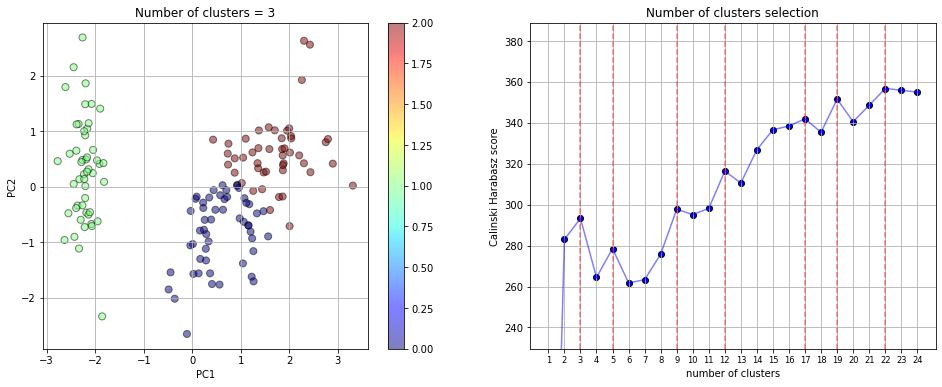

In [193]:
_ = analysis_clustering(X)